In [35]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def get_error(sorted_data, x, p, is_int=False):
    if is_int:
        x = np.round(x)
    n = len(sorted_data)
    li = np.searchsorted(sorted_data, x, side="left")
    ri = np.searchsorted(sorted_data, x, side="right")
    qi = int(p * n)
    if ri < qi:
        return (qi-ri)*1.0/n
    elif li > qi:
        return (li-qi)*1.0/n
    else:
        return 0.0

In [3]:
def human_format(x):
    sigpart = 0
    suffix = ""
    if x < .01:
        return "{:.0e}".format(x)
    if x < 1:
        return "{:.2f}".format(x)
    if x < 1000:
        return "{:.3g}".format(x)
    elif x < 1000000:
        sigpart = x / 1000
        suffix = "k"
    elif x < 1000000000:
        sigpart = x / 1000000
        suffix = "M"
    else:
        sigpart = x / 1000000000
        suffix = "B"
    return "{:.3g}{}".format(sigpart, suffix)

In [4]:
colormap = {
    "cmoments": "C0",
    "tdigest": "C1",
    "yahoo": "C2",
    "spark_gk": "C3",
    "histogram": "C4",
    "sampling": "C5",
    "approx_histogram": "C6",
}
markers = {
    "cmoments": "x",
    "tdigest": "^",
    "yahoo": "s",
    "spark_gk": "+",
    "histogram": "D",
    "sampling": "o",
    "approx_histogram": "<"
}
alg_display_name = {
    "cmoments": "M-Sketch",
    "tdigest": "T-Digest",
    "yahoo": "Merge12",
    "spark_gk": "GK",
    "histogram": "EW-Hist",
    "sampling": "Sampling",
    "approx_histogram": "S-Hist",
}

In [5]:
datasets = ["milan", "exponential", "hepmass", "retail", "occupancy", "power"]
dataset_int = {
    "milan": False,
    "exponential": False,
    "hepmass": False,
    "retail": True,
    "occupancy": False,
    "power": False,
}

In [6]:
dataset_paths = {
    "milan": ("../../datasets/internet-mi-2013-11.csv","internet"),
    "exponential": ("../../datasets/exponential_10M.csv","x"),
    "hepmass": ("../../datasets/hepmass_l.csv","f0"),
    "retail": ("../../datasets/retail_quantity_pos.csv","Quantity"),
    "occupancy": ("../../datasets/occupancy_2.csv","CO2"),
    "power": ("../../datasets/household_power.csv","Global_active_power")
}
sorted_vals = {}
for d in datasets:
    print(d)
    dpath, dcol = dataset_paths[d]
    df = pd.read_csv(dpath)
    sorted_vals[d] = np.sort(df[dcol])

milan
exponential
hepmass
retail
occupancy
power


In [40]:
result_path = "../finalresults/"
point_paths = {
    "milan": ["point_milan_m.csv", "point_milan.csv"],
    "exponential": ["point_exp_m.csv", "point_exp.csv"],
    "hepmass": ["point_hepmass_m.csv", "point_hepmass.csv"],
    "retail": ["point_retail_m.csv", "point_retail.csv"],
    "occupancy": ["point_occupancy_m.csv", "point_occupancy.csv"],
    "power": ["point_power_m.csv", "point_power.csv"],
}
merge_paths = {
    "milan": ["merge_milan.csv"],
    "hepmass": ["merge_hepmass.csv"],
    "exponential": ["merge_exp_m.csv", "merge_exp.csv"]
}
p_datasets = ["milan", "hepmass", "occupancy", "power","retail","exponential", ]
m_datasets = ["milan", "hepmass", "exponential"]

point_dfs = {}
for dname in p_datasets:
    point_dfs[dname] = pd.concat([pd.read_csv(result_path+ppath) for ppath in point_paths[dname]])

merge_dfs = {}
for dname in m_datasets:
    merge_dfs[dname] = pd.concat([pd.read_csv(result_path+ppath) for ppath in merge_paths[dname]])

In [18]:
def process(df, svals, is_int=False):
    df["error"] = df.apply(
        lambda r: get_error(
            svals, r["quantile_estimate"], r["q"], is_int
        ),
        axis=1
    )
    df["rerror"] = df["error"] / np.minimum(df["q"],(1-df["q"]))
    dfg = df[
        (df["trial"] > 0)
    ].groupby(
        ["sketch", "size_param"]
    ).mean().reset_index()
    return dfg

In [19]:
def process2(df, svals, is_int=False):
    df["error"] = df.apply(
        lambda r: get_error(
            svals, r["quantile_estimate"], r["q"], is_int
        ),
        axis=1
    )
    df["rerror"] = df["error"] / np.minimum(df["q"],(1-df["q"]))
    dfg = df[
        (df["trial"] > 0)
    ].groupby(
        ["sketch", "size_param", "trial"]
    ).mean().reset_index()
    df_max = df[
        (df["trial"] > 0)
    ].groupby(
        ["sketch", "size_param", "trial"]
    ).max().reset_index()
    return dfg, df_max

In [41]:
point_results_processed = {}
point_results_max = {}
for dname in p_datasets:
    print(dname)
    svals = sorted_vals[dname]
    df = point_dfs[dname]
    dfs, df_max = process2(df, svals, dataset_int[dname])
    point_results_processed[dname] = dfs
    point_results_max[dname] = df_max

milan
hepmass
occupancy
power
retail
exponential


In [10]:
merge_results_processed = {}
for dname in m_datasets:
    svals = sorted_vals[dname]
    df = merge_dfs[dname]
    dfs = process(df, svals)
    merge_results_processed[dname] = dfs

# Final Plot

In [11]:
sketch_sizes_milan = {
    "tdigest": 5.0,
    "histogram": 100.0,
    "cmoments": 11.0,
    "yahoo": 32.0,
    "spark_gk": 50.0,
    "sampling": 1000.0,
    "approx_histogram": 100.0
}
sketch_sizes_hepmass = {
    "tdigest": 1.5,
    "histogram": 15.0,
    "cmoments": 3.0,
    "yahoo": 32.0,
    "spark_gk": 50.0,
    "sampling": 1000.0,
    "approx_histogram": 100.0
}
sketch_sizes_exp = {
    "tdigest": 1.5,
    "histogram": 40.0,
    "cmoments": 9.0,
    "yahoo": 16.0,
    "spark_gk": 20.0,
    "sampling": 400.0,
    "approx_histogram": 100.0
}
sketch_sizes = {
    "milan": sketch_sizes_milan,
    "hepmass": sketch_sizes_hepmass,
    "exponential": sketch_sizes_exp
}

In [12]:
def bar_plot(ax, ys, log=False, label=False, ylims=None):
    n = len(ys)
    xlocs = np.arange(0, n)
    ax.bar(
        xlocs,
        height=ys,
        log=log,
    )
    if (label):
        rects = ax.patches
        for rect, label in zip(rects, ys):
            height = rect.get_height()
            y_pos = height
            if ylims is not None:
                if y_pos < ylims[0]:
                    y_pos = ylims[0]
            ax.text(
                rect.get_x() + rect.get_width()/2, 
                y_pos,
                human_format(label),
                ha='center', va='bottom', size = 8,
            )
    ax.set_xticks(xlocs)

In [13]:
sketches = [
    "cmoments", "yahoo", "spark_gk", "tdigest", "sampling", "approx_histogram","histogram"
]

In [14]:
h_datasets = ["milan", "hepmass"]

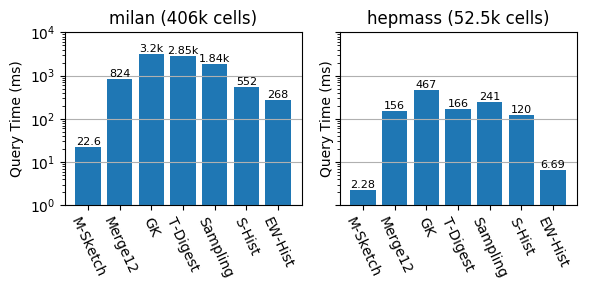

In [259]:
fig, axs = plt.subplots(figsize=(6,3), nrows=1, ncols=len(h_datasets), sharey=True, dpi=100)
for di in range(len(h_datasets)):
    dname = h_datasets[di]
    m_df = point_results_processed[dname]
    dfg = m_df.groupby(["sketch", "size_param"]).mean()
    m_df2 = merge_results_processed[dname]
    dfg2 = m_df2.groupby(["sketch", "size_param"]).mean()

    ax = axs[di]
    ys = []
    names = []
    for cursketch in sketches:
        curkey = (cursketch, sketch_sizes[dname][cursketch])
        cury = dfg.loc[curkey]["query_time"]+dfg2.loc[curkey]["merge_time"]
        ys.append(cury*1e-6)
        names.append(alg_display_name[cursketch])
    ys = np.array(ys)
    bar_plot(ax, ys, log=True, label=True)
    ax.set_xticklabels(names, rotation=-65)
    ax.set_ylabel("Query Time (ms)")
    ax.yaxis.grid(True)
    ax.set_ylim(1, 10000)
    ax.set_title("{} ({} cells)".format(dname, human_format(dfg2.loc[curkey]["n"])))
    
fig.tight_layout()
fig.savefig("h_endquery.pdf", bbox_inches='tight')

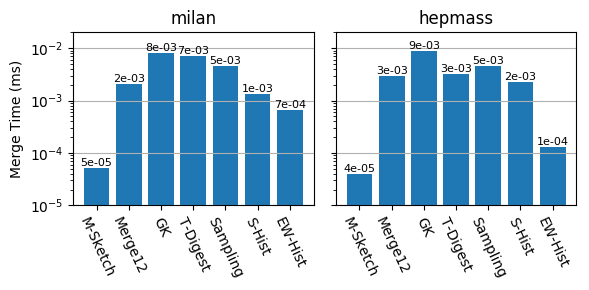

In [260]:
fig, axs = plt.subplots(figsize=(6,3), nrows=1, ncols=len(h_datasets), sharey=True, dpi=100)
for di in range(len(h_datasets)):
    dname = h_datasets[di]
    m_df = merge_results_processed[dname]
    dfg = m_df.groupby(["sketch", "size_param"]).mean()
    
    ax = axs[di]
    ys = []
    names = []
    for cursketch in sketches:
        curkey = (cursketch, sketch_sizes[dname][cursketch])
        ys.append(dfg.loc[curkey]["merge_time"]*1e-6/dfg.loc[curkey]["n"])
        names.append(alg_display_name[cursketch])
    ys = np.array(ys)
    bar_plot(ax, ys, log=True, label=True)
    ax.set_xticklabels(names, rotation=-65)
    if di == 0:
        ax.set_ylabel("Merge Time (ms)")
    ax.set_ylim(1e-5, 2e-2)
    ax.yaxis.grid(True)
    ax.set_title(dname)
    
fig.tight_layout()
fig.savefig("h_merge_time.pdf", bbox_inches='tight')

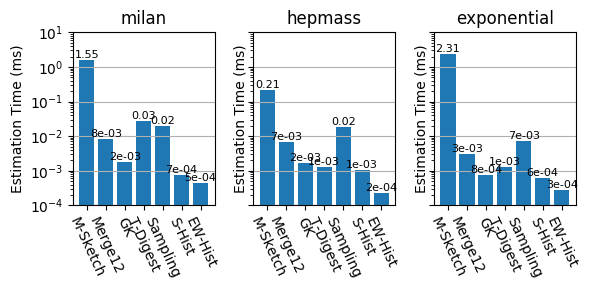

In [261]:
fig, axs = plt.subplots(figsize=(6,3), nrows=1, ncols=len(m_datasets), sharey=True, dpi=100)
for di in range(len(m_datasets)):
    dname = m_datasets[di]
    m_df = point_results_processed[dname]
    dfg = m_df.groupby(["sketch", "size_param"]).mean()
    
    ax = axs[di]
    ys = []
    names = []
    for cursketch in sketches:
        curkey = (cursketch, sketch_sizes[dname][cursketch])
        ys.append(dfg.loc[curkey]["query_time"]*1e-6)
        names.append(alg_display_name[cursketch])
    ys = np.array(ys)
    bar_plot(ax, ys, log=True, label=True)
    ax.set_xticklabels(names, rotation=-65)
    ax.set_ylabel("Estimation Time (ms)")
    ax.set_ylim(1e-4, 10)
    ax.yaxis.grid(True)
    ax.set_title(dname)
    
fig.tight_layout()
fig.savefig("h_est.pdf", bbox_inches='tight')

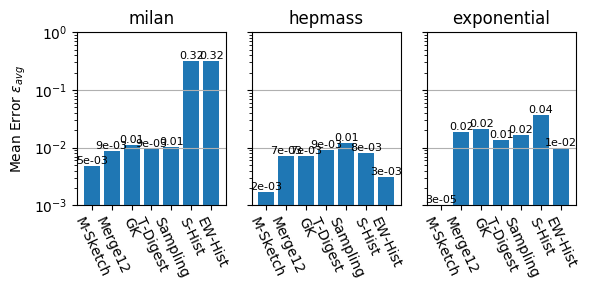

In [262]:
fig, axs = plt.subplots(figsize=(6,3), nrows=1, ncols=len(m_datasets), sharey=True, dpi=100)
for di in range(len(m_datasets)):
    dname = m_datasets[di]
    m_df = point_results_processed[dname]
    dfg = m_df.groupby(["sketch", "size_param"]).mean()
    
    ax = axs[di]
    ys = []
    names = []
    for cursketch in sketches:
        curkey = (cursketch, sketch_sizes[dname][cursketch])
        ys.append(dfg.loc[curkey]["error"])
        names.append(alg_display_name[cursketch])
    ys = np.array(ys)
    bar_plot(ax, ys, log=True, label=True, ylims=(1e-3, .5))
    ax.set_ylim(1e-3, .7)
    ax.set_xticklabels(names, rotation=-65)
    if di == 0:
        ax.set_ylabel("Mean Error $\epsilon_{avg}$")
    ax.set_ylim(1e-3, 1)
    ax.yaxis.grid(True)
    ax.set_title(dname)
    
fig.tight_layout()
fig.savefig("h_error.pdf", bbox_inches='tight')

In [73]:
results = []
for sketch in sketches:
    dfg = point_results_processed["exponential"].groupby(["sketch", "size_param"]).mean()
    crow = dfg.loc[(sketch, sketch_sizes[sketch])]
    cur_result = {}
    cur_result["sketch"] = sketch
    cur_result["size_param"] = sketch_sizes[sketch]
    cur_result["size"] = crow["space"].astype(int)
    results.append(cur_result)
r_df = pd.DataFrame(results)
r_df = r_df[["sketch", "size_param", "size"]].rename(columns={
    "size": "size (bytes)"
})
r_df

,sketch,size_param,size (bytes)
0,cmoments,9.0,168
1,yahoo,16.0,2720
2,spark_gk,20.0,256
3,tdigest,1.5,90
4,approx_histogram,100.0,1216
5,sampling,400.0,3208
6,histogram,40.0,332


In [208]:
r_df.to_csv("sketch_params.csv", index=False)

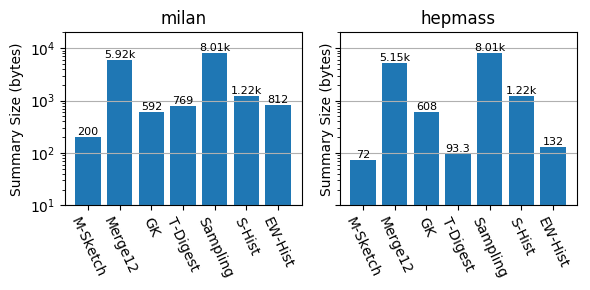

In [264]:
fig, axs = plt.subplots(figsize=(6,3), nrows=1, ncols=2, sharey=True, dpi=100)
for di in range(len(h_datasets)):
    dname = h_datasets[di]
    m_df = point_results_processed[dname]
    dfg = m_df.groupby(["sketch", "size_param"]).mean()
    
    ax = axs[di]
    ys = []
    names = []
    for cursketch in sketches:
        curkey = (cursketch, sketch_sizes[dname][cursketch])
        ys.append(dfg.loc[curkey]["space"])
        names.append(alg_display_name[cursketch])
    ys = np.array(ys)
    bar_plot(ax, ys, log=True, label=True, ylims=(1e-3, .5))
    ax.set_xticklabels(names, rotation=-65)
    ax.set_ylabel("Summary Size (bytes)")
    ax.yaxis.grid(True)
    ax.set_ylim(10, 20000)
    ax.set_title(dname)
    
fig.tight_layout()
fig.savefig("h_size.pdf", bbox_inches='tight')

# Generalization Table

In [184]:
key = ("cmoments", 9.0)
p_metrics = ["query_time", "error", "bound_size"]
p_max_metrics = ["error"]

In [193]:
results = []
for dname in p_datasets:
    cur_result = {}
    cur_result["dataset"] = dname 
    if dname in merge_results_processed:
        mrow = merge_results_processed[dname].groupby(["sketch", "size_param"]).mean().loc[key]
        cur_result["merge_time"] = mrow["merge_time"] / mrow["n"]
    prow = point_results_processed[dname].groupby(["sketch", "size_param"]).mean().loc[key]
    prow_max = point_results_max[dname].groupby(["sketch", "size_param"]).mean().loc[key]
    for metric in p_metrics:
        cur_result[metric] = prow[metric]
    for metric in p_max_metrics:
        cur_result[metric+"_max"] = prow_max[metric]
    results.append(cur_result)
gen_df = pd.DataFrame(results)
gen_df["query_time"] *= 1e-6
gen_df = gen_df[
    ["dataset", "query_time", "error", "error_max", "bound_size"]
]
gen_df["query_time"] = gen_df["query_time"].round(2)
gen_df["error"] = (gen_df["error"]*100).round(2)
gen_df["error_max"] = (gen_df["error_max"]*100).round(2)
gen_df["bound_size"]= (gen_df["bound_size"]*100).round(1)

In [194]:
gen_df

,dataset,query_time,error,error_max,bound_size
0,milan,1.26,1.14,2.50,17.8
1,exponential,2.31,0.00,0.02,24.7
2,hepmass,0.92,0.02,0.10,17.7
3,occupancy,0.74,1.34,4.41,19.8
4,power,1.19,1.05,3.42,17.6
5,retail,11.89,0.81,4.16,20.9


In [231]:
gen_df.to_csv("msketch_gen.csv", index=False)

# Point Accuracy

In [243]:
sketches = [
    "cmoments", "yahoo", "spark_gk", "tdigest", "sampling", "approx_histogram","histogram"
]

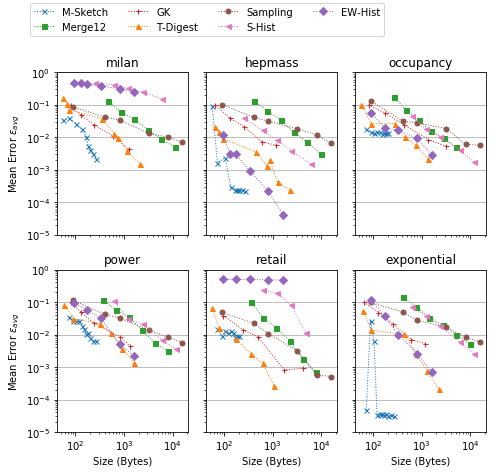

In [42]:
debug=False
if not debug:
    c_datasets = p_datasets
    n_plots = len(c_datasets)
    cfigsize = (7,6)
    n_rows = 2
else:
    n_plots = 6
    c_datasets = p_datasets
    cfigsize = (12,3)
f, axs = plt.subplots(n_rows, int(n_plots/n_rows), figsize=cfigsize, sharey=True, sharex=True)
for di in range(len(c_datasets)):
    dname = c_datasets[di]
    ax = axs.ravel()[di]
    df = point_results_processed[dname].groupby(["sketch", "size_param"]).mean().reset_index()
    lines = []
    labels = []
    for alg in sketches:
        c_df = df[df["sketch"] == alg]
        l, = ax.loglog(
            c_df["space"],
            c_df["error"], 
            label=alg_display_name[alg],
            marker=markers[alg],
            color=colormap[alg],
            markersize=5,
            ls="dotted",
            lw=1
        )
        lines.append(l)
        labels.append(alg_display_name[alg])

    ax.set_title(dname)
    if di > 2:
        ax.set_xlabel("Size (Bytes)")
    ax.yaxis.grid(True)
    ax.set_ylim(1e-5, 1)
    if di%3 == 0:
        ax.set_ylabel("Mean Error $\epsilon_{avg}$")

lgd = f.legend(
    lines, labels,
    bbox_to_anchor=(0.05, 1., 1., .102), ncol=4, loc=2
)
f.tight_layout()
f.savefig("point_accuracy_big.pdf", bbox_extra_artists=(lgd,), bbox_inches='tight')

# Point Solve Time

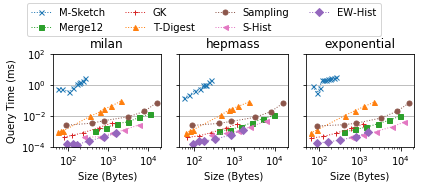

In [43]:
debug=False
if not debug:
    c_datasets = ["milan", "hepmass", "exponential"]
    n_plots = len(c_datasets)
    cfigsize = (6,2.3)
else:
    n_plots = 6
    c_datasets = p_datasets
    cfigsize = (12,3)
# sketches = ["cmoments", "tdigest", "yahoo", "sampling", "spark_gk", "histogram"]
f, axs = plt.subplots(1,n_plots, figsize=cfigsize, sharey=True)
for di in range(len(c_datasets)):
    dname = c_datasets[di]
    ax = axs[di]
    df = point_results_processed[dname].groupby(["sketch", "size_param"]).mean().reset_index()
    lines = []
    labels = []
    for alg in sketches:
        c_df = df[df["sketch"] == alg]
        l, = ax.loglog(
            c_df["space"],
            c_df["query_time"] * 1e-6, 
            label=alg_display_name[alg],
            marker=markers[alg],
            color=colormap[alg],
            markersize=5,
            ls="dotted",
            lw=1
        )
        lines.append(l)
        labels.append(alg_display_name[alg])

    ax.set_title(dname)
    ax.set_ylim(1e-4, 100)
    ax.set_xlabel("Size (Bytes)")
    ax.yaxis.grid(True)
    if di == 0:
        ax.set_ylabel("Query Time (ms)")

lgd = f.legend(
    lines, labels,
    bbox_to_anchor=(0.05, 1.05, 1., .102), ncol=4, loc=2
)
f.tight_layout()
f.savefig("point_solve.pdf", bbox_extra_artists=(lgd,), bbox_inches='tight')

# Point Bound Size

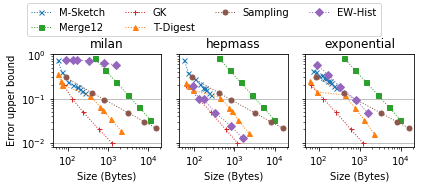

In [44]:
debug=False
if not debug:
    n_plots = 3
    c_datasets = m_datasets
    cfigsize = (6,2.3)
else:
    n_plots = 6
    c_datasets = p_datasets
    cfigsize = (12,3)
    
b_sketches = [
    "cmoments", "yahoo", "spark_gk", "tdigest", "sampling", "histogram"
]
f, axs = plt.subplots(1,n_plots, figsize=cfigsize, sharey=True)
for di in range(len(c_datasets)):
    dname = c_datasets[di]
    ax = axs[di]
    df = point_results_processed[dname].groupby(["sketch", "size_param"]).mean().reset_index()

    lines = []
    labels = []
    for alg in b_sketches:
        c_df = df[df["sketch"] == alg]
        l, = ax.loglog(
            c_df["space"],
            c_df["bound_size"], 
            label=alg_display_name[alg],
            marker=markers[alg],
            color=colormap[alg],
            markersize=5,
            ls="dotted",
            lw=1
        )
        lines.append(l)
        labels.append(alg_display_name[alg])

    ax.set_title(dname)
#     ax.set_xlim(30, 5000)
    ax.set_xlabel("Size (Bytes)")
    ax.yaxis.grid(True)
    if di == 0:
        ax.set_ylabel("Error upper bound")

lgd = f.legend(
    lines, labels,
    bbox_to_anchor=(0.05, 1.05, 1., .102), ncol=4, loc=2
)
f.tight_layout()
f.savefig("point_bound.pdf", bbox_extra_artists=(lgd,), bbox_inches='tight')

# Merge Time

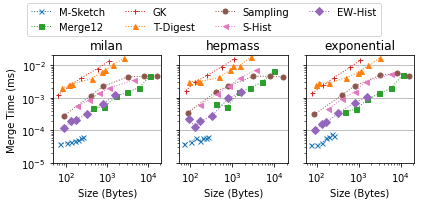

In [32]:
f, axs = plt.subplots(1,3, figsize=(6,2.5), sharey=True)
for di in range(len(m_datasets)):
    dname = m_datasets[di]
    ax = axs[di]
    df = merge_results_processed[dname]
    lines = []
    labels = []
    for alg in sketches:
        c_df = df[df["sketch"] == alg]
        if alg == "cmoments":
            c_df = c_df[c_df["size_param"].astype(int) % 2 == 1]
        l, = ax.loglog(
            c_df["space"],
            c_df["merge_time"]*1e-6 / c_df["n"], 
            label=alg_display_name[alg],
            marker=markers[alg],
            color=colormap[alg],
            markersize=5,
            ls="dotted",
            lw=1
        )
        lines.append(l)
        labels.append(alg_display_name[alg])

    ax.set_title(dname)
    ax.set_ylim(1e-5, 2e-2)
    ax.set_xlabel("Size (Bytes)")
    ax.yaxis.grid(True)
    if di == 0:
        ax.set_ylabel("Merge Time (ms)")

lgd = f.legend(
    lines, labels,
    bbox_to_anchor=(0.05, 1.05, 1., .102), ncol=4, loc=2
)
f.tight_layout()
f.savefig("merge_time.pdf", bbox_extra_artists=(lgd,), bbox_inches='tight')

# Point Update

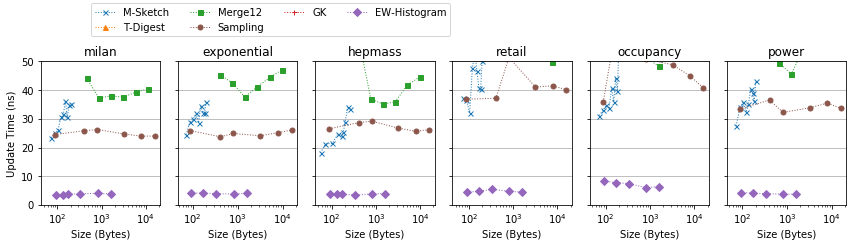

In [221]:
sketches = ["cmoments", "tdigest", "yahoo", "sampling", "spark_gk", "histogram"]
f, axs = plt.subplots(1, len(p_datasets), figsize=(12,3), sharey=True)
for di in range(len(p_datasets)):
    dname = datasets[di]
    ax = axs[di]
    df = point_results_processed[dname].groupby(["sketch", "size_param"]).mean().reset_index()

    lines = []
    labels = []
    for alg in sketches:
        c_df = df[df["sketch"] == alg]
        l, = ax.semilogx(
            c_df["space"],
            c_df["train_time"] / c_df["n"], 
            label=alg_display_name[alg],
            marker=markers[alg],
            color=colormap[alg],
            markersize=5,
            ls="dotted",
            lw=1
        )
        lines.append(l)
        labels.append(alg_display_name[alg])

    ax.set_title(dname)
    ax.set_xlabel("Size (Bytes)")
    ax.yaxis.grid(True)
    ax.set_ylim(0, 50)
    if di == 0:
        ax.set_ylabel("Update Time (ns)")

lgd = f.legend(
    lines, labels,
    bbox_to_anchor=(0.10, 1.05, 1., .102), ncol=4, loc=2
)
f.tight_layout()
f.savefig("point_update.pdf", bbox_extra_artists=(lgd,), bbox_inches='tight')